In [19]:
!python --version

Python 3.10.14


In [20]:

import os
import numpy as np
import pandas as pd
import random

import pims
import trackpy as tp
import imageio
import glob
from PIL import Image

import tensorflow as tf

from keras.models import load_model
from skimage.io import imread
from skimage.transform import resize

import matplotlib  as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


In [21]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10


In [22]:


# Specify the path to your PNG images. Use a wildcard pattern to match all PNG files.
image_path = 'test/*.png'

# List of all PNG files
image_files = sorted(glob.glob(image_path))

# Ensure there are images to process
if not image_files:
    raise ValueError(f"No images found in path: {image_path}")

# Open the first image to start the sequence
first_image = Image.open(image_files[0])

# Convert images to the same mode as the first image if needed
frames = [Image.open(img).convert(first_image.mode) for img in image_files[1:]]

# Save as multi-frame TIFF
output_path = 'test.tif'
first_image.save(output_path, save_all=True, append_images=frames, compression="tiff_deflate")

print(f"Multi-frame TIFF saved to {output_path}")


Multi-frame TIFF saved to test.tif


In [23]:
# To read standard files, including tiff stacks, we can use 
my_fl_img=pims.open('test.tif')

In [24]:
my_fl_img

<Frames>
Source: test.tif
Length: 40 frames
Frame Shape: (1024, 1344, 3)
Pixel Datatype: uint8

(-0.5, 1343.5, 1023.5, -0.5)

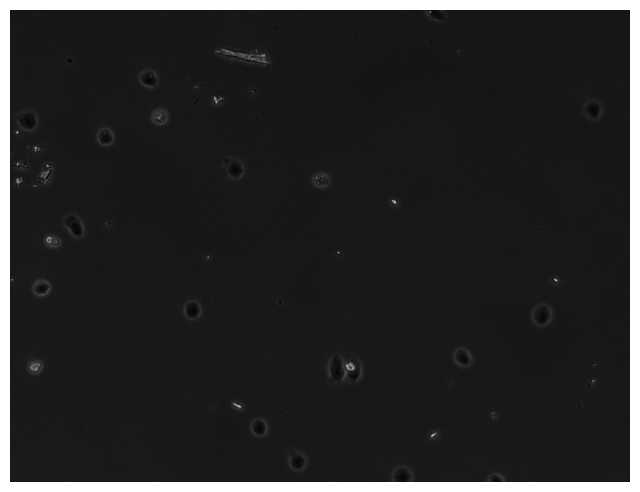

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(my_fl_img[0], cmap='gray')
plt.axis("off")

In [26]:

from csbdeep.utils import normalize

@pims.pipeline
def unet_segm(img):
  img_normalized = normalize(img, 1, 99.8, axis=(0, 1))  # Normalize the image
  prediction = model.predict(np.expand_dims(img_normalized, axis=0))  # Model prediction
  img_labels = np.argmax(prediction, axis=-1).squeeze()  # Assuming your model output needs argmax
  return img_labels


In [27]:
label_image = unet_segm(my_fl_img)

In [28]:
label_image

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: test.tif
    Length: 40 frames
    Frame Shape: (1024, 1344, 3)
    Pixel Datatype: uint8

## Below code Works for new model.

Need to train with data science bowl 2018 data.


40/40 [==============================] - 2s 8ms/step


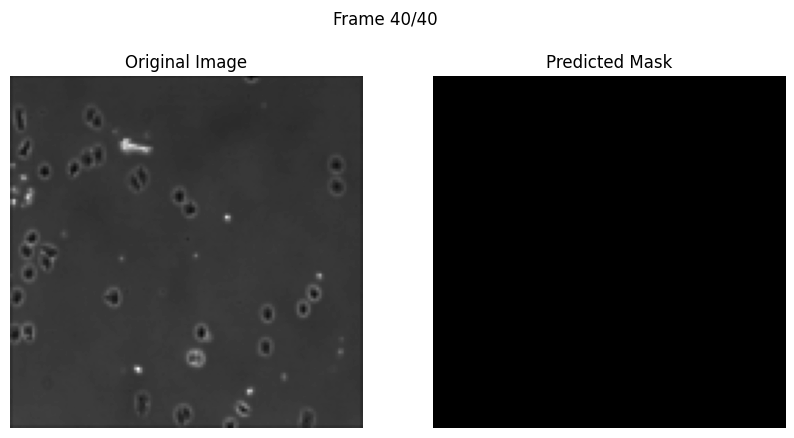

In [29]:
import os
import numpy as np
import pandas as pd
import cv2
import trackpy as tp
import matplotlib.animation as animation
from skimage.io import imread, imshow
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
from keras.models import load_model
import tifffile as tiff

# Load the trained U-Net model
model = load_model('../cell-segmentation/model.h5')

# Directory containing time series PNG images
image_dir = 'test/'

# List of image files
image_files = sorted(os.listdir(image_dir))

# Preprocess images
IMG_HEIGHT = 128  # Example height, update with your model's input size
IMG_WIDTH = 128   # Example width, update with your model's input size

def preprocess_image(image_path):
    image = imread(image_path, as_gray=True)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize
    return image

images = np.array([preprocess_image(os.path.join(image_dir, img)) for img in image_files])

# Predict masks
predicted_masks = model.predict(images, batch_size=1, verbose=1)

# Convert predictions to binary masks
binary_masks = (predicted_masks > 0.9).astype(np.uint8)

# Set up a plot to display images and masks side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    for ax in axes:
        ax.clear()
    # Display original image
    axes[0].imshow(images[frame, :, :, 0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    # Display predicted mask
    axes[1].imshow(binary_masks[frame, :, :, 0], cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    fig.suptitle(f'Frame {frame + 1}/{len(images)}')

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=500, repeat=True)

# Save the animation as a GIF (optional)
ani.save('segmentation_animation.gif', writer='imagemagick')

plt.show(plt.show(block=True))

## for old unet


Single Imgage Prediction with unet model


1/1 [==============================] - 1s 553ms/step


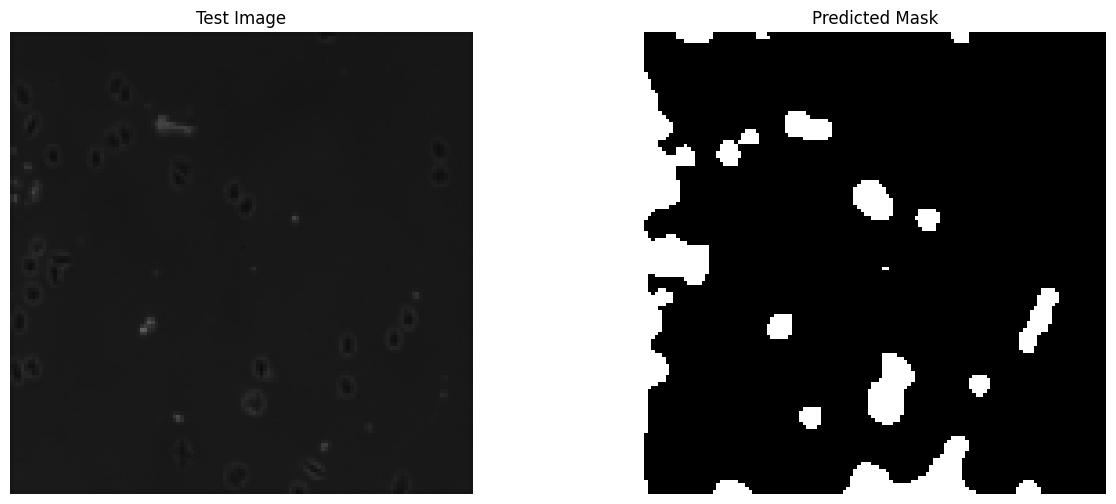

In [30]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path to the saved model
model_path = r"..\cell-segmentation\U-net-model.h5"

# Path to the test image
TEST_IMAGE_PATH = 'test/'

# Function to preprocess test images
def preprocess_test_image(image_path):
    img = imread(image_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    return img

# Load the saved model
model = load_model(model_path)

# Check if the test image directory exists
if os.path.exists(TEST_IMAGE_PATH):
    # Choose a random test image
    test_image_id = random.choice(os.listdir(TEST_IMAGE_PATH ))
    test_image = preprocess_test_image(TEST_IMAGE_PATH + test_image_id)

    # Expand the dimensions of the test image to create a batch of size 1
    test_image_batch = np.expand_dims(test_image, axis=0)

    # Predict segmentation mask
    pred_mask = model.predict(test_image_batch)

    # Threshold the predicted mask
    pred_mask_thresholded = (pred_mask > 0.5).astype(np.uint8)

    # Plot the test image and predicted mask
    plt.figure(figsize=(15, 6))

    # Test image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.astype(np.uint8))
    plt.title('Test Image')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(pred_mask_thresholded), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()
else:
    print("Test image directory does not exist or is empty.")


Works for old model with data science bowl 2018 data.

Time Lapse Prediction with unet model


40/40 [==============================] - 1s 9ms/step


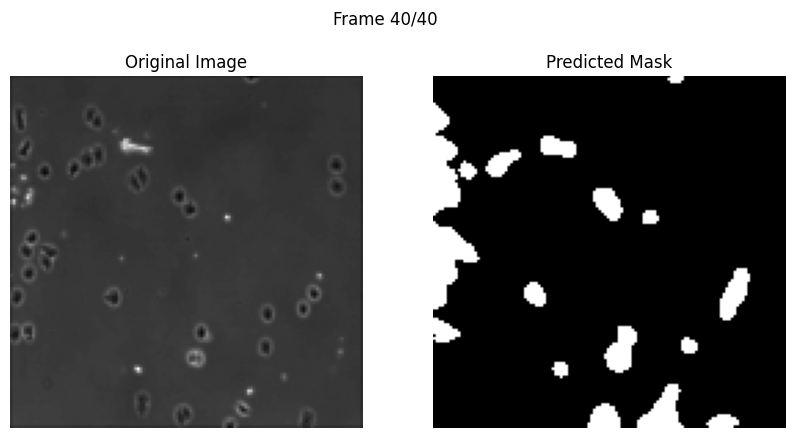

In [31]:
import os
import numpy as np
import pandas as pd
import cv2
import trackpy as tp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.io import imread, imshow
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
from keras.models import load_model
import tifffile as tiff


# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path to the saved model
model_path = r"..\cell-segmentation\U-net-model.h5"

# Path to the test image
TEST_IMAGE_PATH = 'test/'

image_files = sorted(os.listdir(TEST_IMAGE_PATH))

# Function to preprocess test images
def preprocess_test_image(image_path):
    image = imread(image_path)[:,:,:IMG_CHANNELS]
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    return image

# Load the saved model
model = load_model(model_path)

images = np.array([preprocess_test_image(os.path.join(TEST_IMAGE_PATH, img)) for img in image_files])

# Predict masks
predicted_masks = model.predict(images, batch_size=1, verbose=1)

# Convert predictions to binary masks
binary_masks = (predicted_masks > 0.7).astype(np.uint8)

# Set up a plot to display images and masks side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    for ax in axes:
        ax.clear()
    # Display original image
    axes[0].imshow(images[frame, :, :, 0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    # Display predicted mask
    axes[1].imshow(binary_masks[frame, :, :, 0], cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    fig.suptitle(f'Frame {frame + 1}/{len(images)}')

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=500, repeat=True)

# Save the animation as a GIF (optional)
ani.save('segmentation_animation_unet.gif', writer='imagemagick')

plt.show(plt.show(block=True))



for tiff files

40/40 [==============================] - 1s 10ms/step


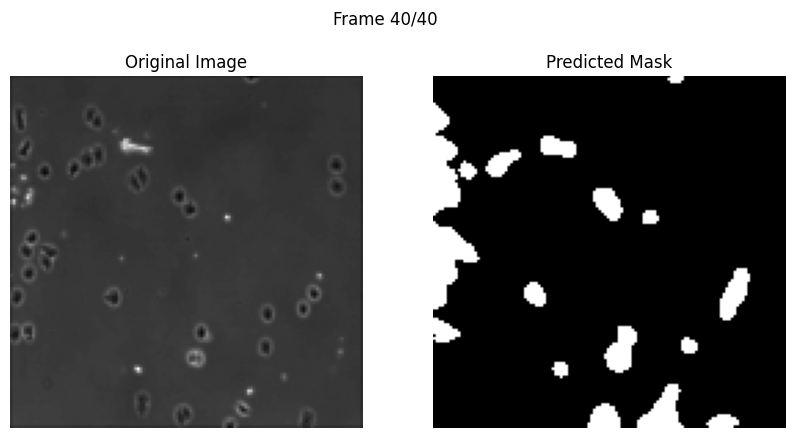

In [33]:
import os
import numpy as np
import pandas as pd
import cv2
import trackpy as tp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.io import imread, imshow
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
from keras.models import load_model
import tifffile as tiff


# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path to the saved model
model_path = r"..\cell-segmentation\U-net-model.h5"

# Path to the TIFF file
TIFF_FILE_PATH = 'test.tif'

# Function to preprocess test images
def preprocess_test_image(image):
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    return image

# Load the saved model
model = load_model(model_path)

# Read the TIFF file
images = tiff.imread(TIFF_FILE_PATH)

# Preprocess images
images = np.array([preprocess_test_image(img) for img in images])

# Predict masks
predicted_masks = model.predict(images, batch_size=1, verbose=1)

# Convert predictions to binary masks
binary_masks = (predicted_masks > 0.7).astype(np.uint8)

# Set up a plot to display images and masks side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    for ax in axes:
        ax.clear()
    # Display original image
    axes[0].imshow(images[frame, :, :, 0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    # Display predicted mask
    axes[1].imshow(binary_masks[frame, :, :, 0], cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    fig.suptitle(f'Frame {frame + 1}/{len(images)}')

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=500, repeat=True)

# Save the animation as a GIF (optional)
ani.save('segmentation_animation_unet.gif', writer='imagemagick')

plt.show(plt.show(block=True))


40/40 [==============================] - 1s 9ms/step


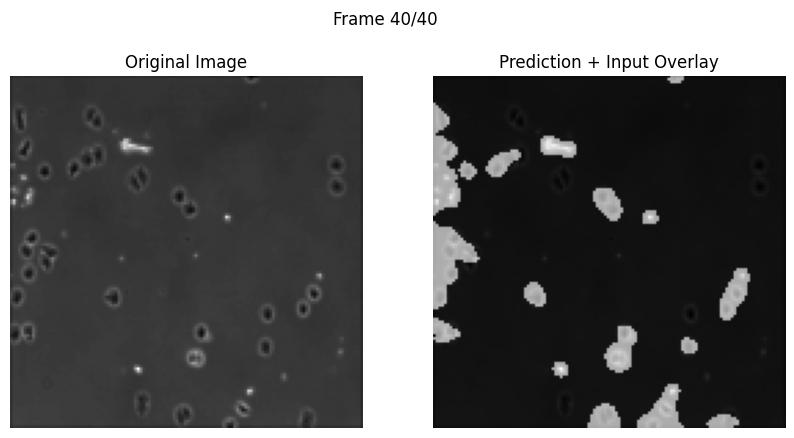

In [14]:
import os
import numpy as np
import pandas as pd
import cv2
import trackpy as tp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.io import imread, imshow
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
from keras.models import load_model
import tifffile as tiff

# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path to the saved model
model_path = r"..\cell-segmentation\U-net-model.h5"

# Path to the TIFF file
TIFF_FILE_PATH = 'test.tif'

# Function to preprocess test images
def preprocess_test_image(image):
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    return image

# Load the saved model
model = load_model(model_path)

# Read the TIFF file
images = tiff.imread(TIFF_FILE_PATH)

# Preprocess images
images = np.array([preprocess_test_image(img) for img in images])

# Predict masks
predicted_masks = model.predict(images, batch_size=1, verbose=1)

# Convert predictions to binary masks
binary_masks = (predicted_masks > 0.7).astype(np.uint8)

# Set up a plot to display images and masks side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    for ax in axes:
        ax.clear()
    # Display original image
    axes[0].imshow(images[frame, :, :, 0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    # Overlay predicted mask on the original image
    overlay = images[frame].copy()
    overlay[:,:,0] += 100 * np.expand_dims(binary_masks[frame, :, :, 0], axis=2)

    axes[1].imshow(overlay[:,:,0], cmap='gray')
    axes[1].set_title('Prediction + Input Overlay')
    axes[1].axis('off')
    fig.suptitle(f'Frame {frame + 1}/{len(images)}')

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=500, repeat=True)

# Save the animation as a GIF using matplotlib
ani.save('segmentation_animation_u3.gif', writer='pillow')

plt.show(block=True)
